# Linear and angular velocity

We have seen how to look up and transform positions and orientations across reference frames in the previous section. Working with velocities adds some complexity that will be explained in this section.

<div class="alert alert-info">
Note
    
The following examples require the `matplotlib` library.
</div>

In [1]:
import numpy as np
import rigid_body_motion as rbm
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6, 6)

## Setting up

Like in the previous section, we first set up the world frame:

In [2]:
rbm.register_frame("world")

For simplicity, all reference frames will share the same timestamps:

In [3]:
n_timestamps = 5
ts = np.linspace(0, 5, n_timestamps)

We define a body moving 5 meters in the x direction:

In [4]:
p_body_world = np.zeros((n_timestamps, 3))
p_body_world[:, 0] = np.linspace(0, 5, n_timestamps)

In addition, this body will rotate 90° around the z axis. We use helper functions from the `quaternion` package for this:

In [5]:
from quaternion import as_float_array, from_euler_angles

o_body_world = as_float_array(
    from_euler_angles(np.linspace(0, np.pi / 4, n_timestamps), 0, 0)
)

Now we can attach a reference frame to this body:

In [6]:
rbm.register_frame(
    "body",
    translation=p_body_world,
    rotation=o_body_world,
    timestamps=ts,
    parent="world",
)

We now define a second moving body whose motion we describe wrt the frame of the first body. It is located at 1 meter in the y direction and moves 1 meter in the negative x direction.

In [7]:
p_body2_body = np.zeros((n_timestamps, 3))
p_body2_body[:, 0] = -np.linspace(0, 1, n_timestamps)
p_body2_body[:, 1] = 1

This body also rotates, but this time around the y axis:

In [8]:
o_body2_body = as_float_array(
    from_euler_angles(0, np.linspace(0, np.pi / 4, n_timestamps), 0)
)

Now we can register a frame attached to the second body as a child frame of the first body frame:

In [9]:
rbm.register_frame(
    "body2",
    translation=p_body2_body,
    rotation=o_body2_body,
    timestamps=ts,
    parent="body",
)

Let's plot the position and orientation of both bodies wrt the world frame. We use the [lookup_pose()](_generated/rigid_body_motion.lookup_pose.rst) method to obtain the position of the second body in the world frame:

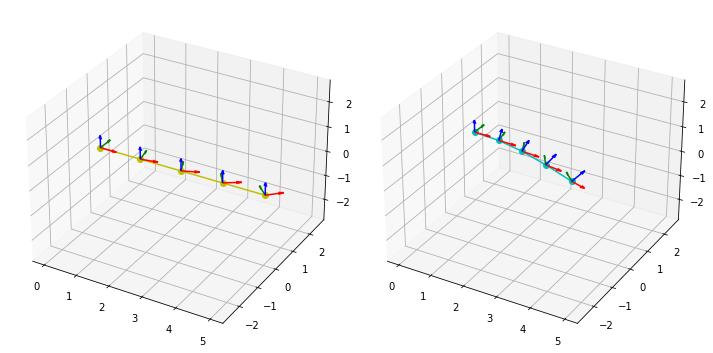

In [10]:
p_body2_world, o_body2_world = rbm.lookup_pose("body2", "world")

fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(121, projection="3d")
rbm.plot.points(p_body_world, ax=ax, fmt="yo-")
rbm.plot.quaternions(o_body_world, base=p_body_world, ax=ax)

ax = fig.add_subplot(122, projection="3d", sharex=ax, sharey=ax, sharez=ax)
rbm.plot.points(p_body2_world, ax=ax, fmt="co-")
rbm.plot.quaternions(o_body2_world, base=p_body2_world, ax=ax)

fig.tight_layout()

## Linear velocity

The linear velocity of a frame wrt another frame can be calculated with the [lookup_linear_velocity()](_generated/rigid_body_motion.lookup_linear_velocity.rst) method:

In [11]:
v_body2_body = rbm.lookup_linear_velocity("body2", "body")
v_body2_body[0]

array([-0.2,  0. ,  0. ])

As expected, the velocity of the second body wrt the first body $v_{B2/B}$ is 0.2 m/s in the negative x direction. Next, we will see how we can obtain the velocity of the second body wrt the world frame $W$.

### Transforming the reference frame

When transforming linear velocities across frames, we need to use the so-called "three term velocity formula". In this case, we have the velocity of the _moving frame_ $B2$ wrt the _reference frame_ $B$. We can transform the current reference frame $B$ to the new frame $W$ as follows:

$$v_{B2/W} = \underbrace{v_{B2/B}}_{\text{Input}} + \underbrace{v_{B/W} + \omega_{B/W} \times t_{B2/B}}_{\text{Lookup}}$$

In addition to the velocities between the reference frames $B$ and $W$, this formula also requires the translation between the moving frame $B2$ and the original reference frame $B$. This is why we also need to specify the `moving_frame` argument when using [transform_linear_velocity()](_generated/rigid_body_motion.transform_linear_velocity.rst):

In [12]:
v_body2_world = rbm.transform_linear_velocity(
    v_body2_body, outof="body", into="world", moving_frame="body2", timestamps=ts,
)

Alternatively, we can also use [lookup_linear_velocity()](_generated/rigid_body_motion.lookup_linear_velocity.rst) to lookup the position of $B2$ wrt $W$ and differentiate:

In [13]:
v_body2_world_lookup = rbm.lookup_linear_velocity("body2", "world")

The following short helper function can be used to compare the two methods:

In [14]:
def compare_velocities(transform, lookup, timestamps=None, mode="linear"):
    """ Compare velocities from transform and lookup. """
    fig, axarr = plt.subplots(2, 1, sharex=True, sharey=True)

    ylabel = f"{mode.capitalize()} velocity ({'rad/s' if mode == 'angular' else 'm/s'})"

    axarr[0].plot(timestamps, transform)
    axarr[0].set_ylabel(ylabel)
    axarr[0].set_title("Transform")

    axarr[1].plot(timestamps, lookup)
    axarr[1].set_xlabel("Time (s)")
    axarr[1].set_ylabel(ylabel)
    axarr[1].set_title("Lookup")
    axarr[1].legend(["x", "y", "z"])

    fig.tight_layout()

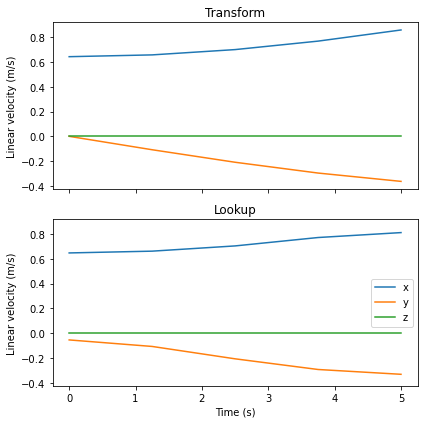

In [15]:
compare_velocities(v_body2_world, v_body2_world_lookup, ts)

We see a slight discrepancy due to numerical inconsistencies in the derivative calculation. However, these errors are reduced at higher sampling rates.

### Transforming the moving frame

In a different scenario, we might be given the velocity of the first body wrt the world frame and want to transform the _moving frame_ from $B$ to $B2$ to compute the velocity of the second body wrt $W$. The same formula applies, although this time the input is $v_{B/W}$:

$$v_{B2/W} = \underbrace{v_{B/W}}_{\text{Input}} + \underbrace{v_{B2/B} + \omega_{B/W} \times t_{B2/B}}_{\text{Lookup}}$$

When using [transform_linear_velocity()](_generated/rigid_body_motion.transform_linear_velocity.rst) we need to be careful that the velocity is represented in the coordinates of the frame we want to transform. Therefore, $v_{B/W}$ has to be represented in $B$:

In [16]:
v_body_world = rbm.lookup_linear_velocity("body", "world", represent_in="body")

Now we can use [transform_linear_velocity()](_generated/rigid_body_motion.transform_linear_velocity.rst) with `what="moving_frame"` to transform from $B$ to $B2$. Since the method needs to look up $\omega_{B/W}$, this time we need to provide the `reference_frame` of the velocity:

In [17]:
v_body2_world = rbm.transform_linear_velocity(
    v_body_world,
    outof="body",
    into="body2",
    reference_frame="world",
    what="moving_frame",
    timestamps=ts,
)

Let's compare this result against the lookup method again. Note that the transformation also changes the representation frame to the new frame, which is why the resulting velocity is different compared to the first case:

In [18]:
v_body2_world_lookup = rbm.lookup_linear_velocity("body2", "world", represent_in="body2")

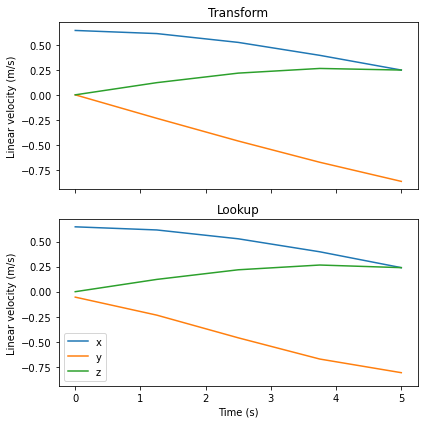

In [19]:
compare_velocities(v_body2_world, v_body2_world_lookup, ts)

## Angular velocity

Angular velocities can be looked up with [lookup_angular_velocity()](_generated/rigid_body_motion.lookup_angular_velocity.rst):

In [20]:
w_body2_body = rbm.lookup_angular_velocity("body2", "body")
w_body2_body[0]

array([0.        , 0.15708158, 0.        ])

### Transforming the reference frame

Transforming the reference frame of angular velocity is similar to the case of linear velocity, although the formula is a lot simpler:

$$\omega_{B2/W} = \underbrace{\omega_{B2/B}}_{\text{Input}} + \underbrace{\omega_{B/W}}_{\text{Lookup}}$$

Because of this, [transform_angular_velocity()](_generated/rigid_body_motion.transform_angular_velocity.rst) also has a simpler interface:

In [21]:
w_body2_world = rbm.transform_angular_velocity(
    w_body2_body, outof="body", into="world", timestamps=ts
)

Comparing the transform to the lookup shows no differences in the result:

In [22]:
w_body2_world_lookup = rbm.lookup_angular_velocity("body2", "world")

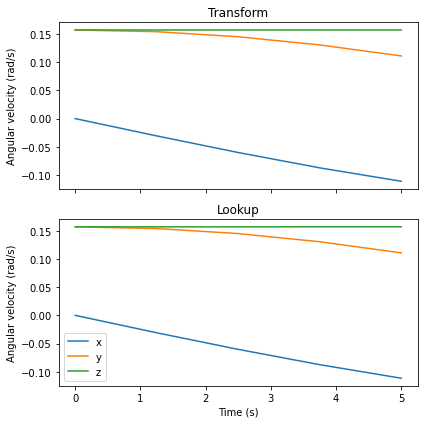

In [23]:
compare_velocities(w_body2_world, w_body2_world_lookup, ts, mode="angular")

### Transforming the moving frame

As before, we can also transform the moving frame:

$$\omega_{B2/W} = \underbrace{\omega_{B/W}}_{\text{Input}} + \underbrace{\omega_{B2/B}}_{\text{Lookup}}$$

In [24]:
w_body_world = rbm.lookup_angular_velocity("body", "world", represent_in="body")

In [25]:
w_body2_world = rbm.transform_angular_velocity(
    w_body_world, outof="body", into="body2", what="moving_frame", timestamps=ts,
)

In [26]:
w_body2_world_lookup = rbm.lookup_angular_velocity("body2", "world", represent_in="body2")

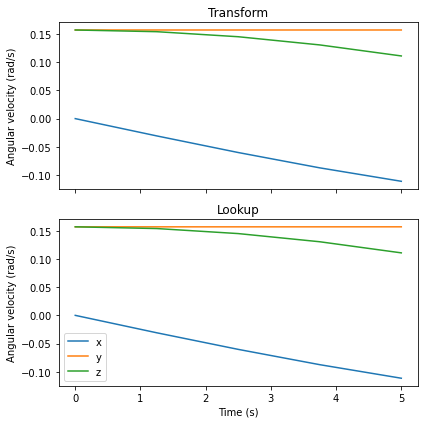

In [27]:
compare_velocities(w_body2_world, w_body2_world_lookup, ts, mode="angular")